# Python interface: practical guide

***Part 1: calling C++ from Python*** 

In this first part use the *spinfoam.py* module in order to call C++ source code implemented in the `./src` folder.
We do this by using the spinfoam shared library.

This allows us to take full advantage of the efficiency of the C++ code in order to deal with the most hard (computationally speaking) sections of the algorithm.

***Part 2: pure Python***   

In this second part we manipulate the csv files, computed and stored in the first part, with pure Python code.
We also make some plots with the collected data.

**Let's start!**

## Step 0: computing the required fastwigxj hash tables

First, we must compute all the necessary hash tables of 3j, 6j and 9j Wigner symbols.
These tables are, in fact, a key ingredient for *step 1* and *step 2*.

For the calculation, we use the _wigxjpf_ and _fastwigxj_ libraries [Johansson et al., 2015], stored under `./ext/`.

In the following, with "type x" I mean "type x in linux shell terminal"

1. Change directory to `./ext/wigxjpf/`, type **make**.
2. Change directory to `./ext/fastwigxj/`, type **make**. 
   In in the followng, the latter is supposed to be the current directory.
   
3. Type "bin/hash_js --max-E-3j=50 /dev/null ./table_50.3j".
4. Type "bin/hash_js --max-E-6j=40 /dev/null ./table_40.6j".
5. Type "bin/gen_9j --flat-lim=16 | bin/combine_js | bin/unique_js ./comb_16.9j".
6. Type "bin/hash_js ./comb_16.9j ./hashed_16.9j".
7. Move the hash tables "hashed_16.9j", "table_40.6j" and "table_50.3j" generated in steps 3-6 in a directory of your choice.
   
   For example, create a folder `./ext/fastwigxj_generated_tables/` and move all the hash tables in it.

   This is the default folder which I refer to in the following, but you can also choose another folder and provide a different 
   path.
   
**Important**: when using Jupyter notebook, if the hash table is not found in the provided path, the kernel dies with no message. 

When using python script from linux terminal, the C++ returns an error message which is correctly printed. 

Therefore, we must be sure that the fastwigxj hash tables above are actually stored before moving on.  

## Step 1: creating the **spinfoam** shared library

We first import the *spinfoam.py* module 

In [1]:
import spinfoam as sf

We can always clean all the previous binary and object files, as well as the shared library along with the corresponding folders, with the following cell

In [2]:
sf.spinfoam_clean()

rm -rf obj
rm -rf lib
rm -rf bin


We can compile and generate all the required files with the following cell, provided that *all dependencies are satisifed*.

For details, see the README file.

Notice that you can also compile in debug mode with **spinfoam_compile_debug()**

In [2]:
sf.spinfoam_compile()

make: Nessuna operazione da eseguire per «default».


### Step 2: Hashing tables of 21j Wigner symbols 

We now compute the 21j Wigner symbols hash tables.
These  are a key ingredient for the Metropolis-Hastings algorithm, as they will be will be retrieved in *step 3*.

We use [parallel hashmap](https://github.com/greg7mdp/parallel-hashmap) in order to efficiently store and dump to disk the Wigner symbols. 

All the necessary _fastwigxj_ hash tables of 3j, 6j and 9j Wigner symbols must have been previously computed and stored in `./ext/fastwigxj_generated_tables/` (or another folder of your choice, provided that the correct path is provided to the function below). See *step 0* for details

The C++ code searches for all files in the provided folder with extension ".3j", ".6j" or ".9j", and the largest tables found are set for loading.   

In [3]:
# this is the folder with the pre-computed hash tables of 3j, 6j and 9j Wigner symbols.
# Jupyter kernel dies if tables are not found (C function returns "EXIT FAILURE")
fastwigxj_tables_path = "./private_ext/fastwigxj_generated_tables"

# this is the folder in which we wanto to store the computed 21j symbols hash tables
hash_tables_path = "./ext/hashed_21j"

In [10]:
# 'spin' is the value of all boundary spins of the spinfoam

for spin in [0.5, 1, 1.5, 2]:
    sf.Hashing_21j_symbols(hash_tables_path, fastwigxj_tables_path, spin)

Hashing all 21j symbols with j <= 0.5...
Completed! The hash table has been stored
Hashing all 21j symbols with j <= 1...
Completed! The hash table has been stored
Hashing all 21j symbols with j <= 1.5...
Completed! The hash table has been stored
Hashing all 21j symbols with j <= 2...
Completed! The hash table has been stored


### Step 3: Metropolis-Hastings 

We can now compute and assemble the Markov chains by running the MH algorithm. The computed draws are stored in the given folder.

**We run in parallel an independent Markov chain for each provided thread**.

*It is advisable for the performance to use a number of Markov chains equal to or less than the physical number of cores present on the system.*

Each thread retrieves from the 21j hash table (computed in step 2) the required symbol.

In [8]:
# folder in which we want to store the data
data_folder = "./data_folder"

# this is the folder with the pre-computed hash tables of 21j Wigner symbols (see Step 2).
# Jupyter kernel dies if table is not found (C function returns "EXIT FAILURE")
hash_tables_path = "./ext/hashed_21j"

# MH parameters
spin = 0.5
length = 1000000
sigma = 0.4
burnin = 10
verbosity = 0

# set optimal number of threads
import multiprocessing
number_of_threads = int(multiprocessing.cpu_count())
print(f"optimal number of threads: {number_of_threads}")

optimal number of threads: 12


In [7]:
sf.Metropolis_Hastings_parallel_run(data_folder, hash_tables_path, spin,
                                    length, sigma, burnin, verbosity,
                                    number_of_threads)

Starting 12 independent Markov chains...
Completed! All draws have been stored


### Step 4: Computing angle expectation values

We now manipulate the csv files, computed in *step 3*, in order to extract the informations we are interested in.

For example, let's compute the expectation values of boundary angle operators.

In the cell below, we process the draws previously computed and stored in Step 3.

In order to achieve this, we employ *multiple threads* along with the optimized numpy routines.
Performance improves proportionally to the number of CPU cores on the system.

For each csv file (stored by a different Markov chain), we compute the average of the angle operator
over all the 16 boundary intertwiners.

In [9]:
sf.angles_compute(data_folder, spin, length, sigma, burnin, number_of_threads)

df = sf.retrieve_combined_angles(data_folder, spin, number_of_threads)

Converting 12 chains from draws to averaged angles...
Completed! All draws have been processed
Assembling 12 chains...
Done


In [10]:
df

,angles_average,angles_std,angles_quantum_spread,chains_length,chains_assembled,sigma,burnin
j=0.5,-0.333039,0.001599,0.666665,1000000,12,0.4,10


# Plots

We report here some plots used in the draft. 

The data used for the draft, computed with the Graham and Narval Compute Canada clusters, are available in the folder: `./public_final_data`.

The bash scripts used to collect the latter can be found in the current folder.

In [16]:
import pandas as pd

angles_dataframe = pd.read_csv("./public_final_data/combined_angles_CC.csv", index_col=0)

In [17]:
angles_dataframe

,angles_average,angles_std,angles_quantum_spread,chains_length,chains_assembled,sigma,burnin
j=0.5,-0.333306,0.001951,0.666664,1000000,30,0.40,10
j=1,-0.333691,0.003134,0.630727,1000000,30,0.35,10
j=1.5,-0.332742,0.003280,0.626311,1000000,30,0.35,10
j=2,-0.333616,0.003574,0.627462,1000000,30,0.35,10
j=2.5,-0.333225,0.004635,0.630208,1000000,30,0.35,10
j=3,-0.334483,0.005760,0.632264,1000000,30,0.35,10
j=3.5,-0.334048,0.007164,0.635135,1000000,30,0.32,10
j=4,-0.332651,0.011155,0.636463,1000000,30,0.30,10


In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rc
import pandas as pd
import numpy as np

# Setting plot style

sns.set()
sns.set_context("paper", font_scale=1.5, rc={"lines.linewidth": 2.0})

rc('text', usetex=True)

sns.set_style("ticks")
sns.set_style(
    "whitegrid", {
        'axes.edgecolor':
        'black',
        'axes.grid':
        True,
        'axes.axisbelow':
        True,
        'axes.labelcolor':
        '.15',
        'grid.color':
        '0.9',
        'grid.linestyle':
        '-',
        'xtick.direction':
        'in',
        'ytick.direction':
        'in',
        'xtick.bottom':
        True,
        'xtick.top':
        True,
        'ytick.left':
        True,
        'ytick.right':
        True,
        'font.family': ['sans-serif'],
        'font.sans-serif':
        ['Liberation Sans', 'Bitstream Vera Sans', 'sans-serif'],
    })


## Statistical fluctuations of angles operator

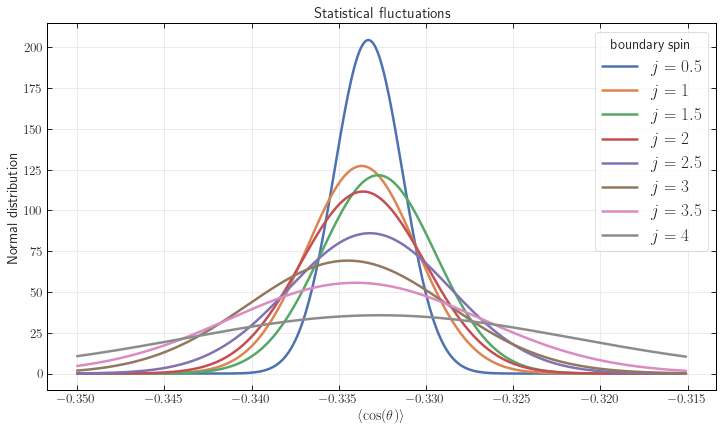

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

#x-axis ranges from -5 and 5 with .001 steps
x = np.arange(-0.35, -0.315, 0.0001)

plt.figure(figsize=(12, 6.75))

#define multiple normal distributions

for spin in [0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4]:

    plt.plot(x,
         norm.pdf(x, angles_dataframe["angles_average"][f"j={spin}"], angles_dataframe["angles_std"][f"j={spin}"]),
         label=f'$j = {spin}$',
         linewidth=2.5)

#add legend to plot
plt.legend(title='boundary spin',
           loc='upper right',
           fontsize='large',
           fancybox=True)

#add axes labels and a title
plt.ylabel('Normal distribution')
plt.xlabel(r"$\langle \cos (\theta) \rangle$")
plt.title('Statistical fluctuations', fontsize=15)

printfile = './plots/angles_fluctuations'
plt.savefig(printfile+'.svg')
plt.savefig(printfile+'.png',dpi=300)

plt.show()

## Expectation values of angle operator

In [9]:
angles_average = [-0.3334329648852039, -0.3336911744117442, -0.3327424146463688, -0.33361569067079594, 
                  -0.3332254129684163, -0.33448275454976717, -0.334048, -0.332651]
regular_values = [-0.3333333333, -0.3333333333, -0.3333333333, -0.3333333333, -0.3333333333, -0.3333333333, -0.3333333333, -0.3333333333]
corresponding_spin = [0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4]

In [10]:
df = pd.DataFrame({
    "spin": corresponding_spin,
    "angles_average": angles_average,
    "regular_values": regular_values
})


In [11]:
df

,spin,angles_average,regular_values
0,0.5,-0.333433,-0.333333
1,1.0,-0.333691,-0.333333
2,1.5,-0.332742,-0.333333
3,2.0,-0.333616,-0.333333
4,2.5,-0.333225,-0.333333
5,3.0,-0.334483,-0.333333
6,3.5,-0.334048,-0.333333
7,4.0,-0.332651,-0.333333


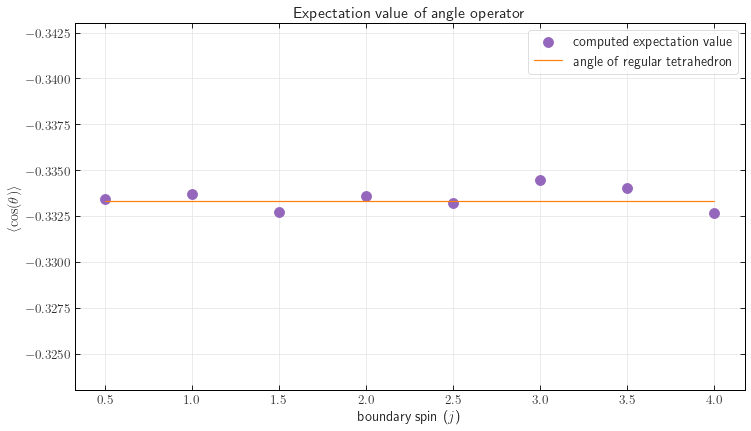

In [16]:
ax = df.plot(x='spin',
             y='angles_average',
             s=100,
             xticks=corresponding_spin,
             kind='scatter',
             grid='false',
             color='tab:purple',
             label='computed expectation value',
             figsize=(12, 6.75))
df.plot(x='spin',
        y='regular_values',
        ax=ax,
        kind='line',
        color='tab:orange',
        linewidth=1.2,
        label='angle of regular tetrahedron')
plt.legend(fontsize = 14)
ax.set_ylim([-0.323, -0.343])
plt.ylabel(r"$\langle \cos (\theta) \rangle$")
plt.xlabel("boundary spin ($j$)")
plt.title('Expectation value of angle operator', fontsize=16)

#---- Uncomment to save. First give a name. Then a high resolution png and svg files are generated

printfile = 'angles_exp_values'
plt.savefig(printfile+'.svg')
plt.savefig(printfile+'.png',dpi=300)

plt.show()

## Loglog plot (with fit) of hash tables size

We want to understand how fast the size of 21j Wigner symbols hash tables increases as a function of boundary spin j

In [17]:
size_hash_tables_in_MB = [
    12.8e-03, 409.5e-03, 6.55, 52.42, 209.71, 838.86, 3.35e+03, 6.71e+03
]
corresponding_spin = [0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4]

# fit log(size) = m*log(j) + c
m, c = np.polyfit(np.log(corresponding_spin),
                  np.log(size_hash_tables_in_MB),
                  1,
                  w=np.sqrt(size_hash_tables_in_MB))
size_fit = np.exp(m * np.log(corresponding_spin) + c)

df = pd.DataFrame({
    "spin": corresponding_spin,
    "table_size": size_hash_tables_in_MB,
    "fitted_data": size_fit
})


In [18]:
df

,spin,table_size,fitted_data
0,0.5,0.0128,0.004545
1,1.0,0.4095,0.526787
2,1.5,6.5500,8.492613
3,2.0,52.4200,61.053381
4,2.5,209.7100,281.963782
5,3.0,838.8600,984.273892
6,3.5,3350.0000,2832.373455
7,4.0,6710.0000,7075.943061


In [19]:
from matplotlib.ticker import ScalarFormatter

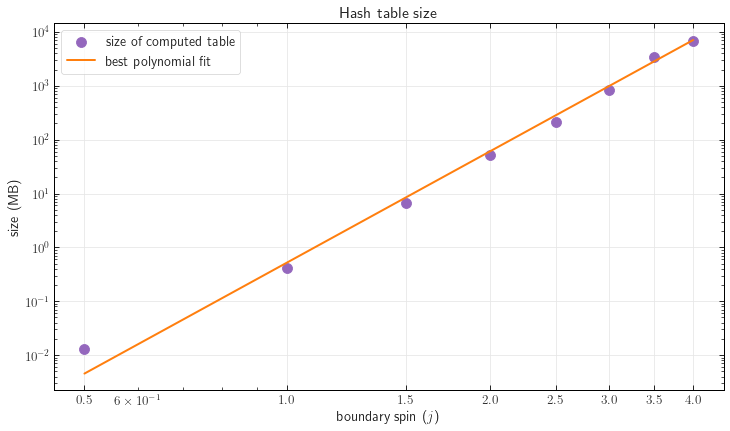

In [21]:
ax = df.plot(x='spin',
             y='table_size',
             s=100,
             xticks=corresponding_spin,
             kind='scatter',
             grid='false',
             color='tab:purple',
             label='size of computed table',
             logy=True,
             logx=True,
             figsize=(12, 6.75))
df.plot(x='spin',
        y='fitted_data',
        ax=ax,
        kind='line',
        color='tab:orange',
        label='best polynomial fit')
plt.legend(fontsize = 14)
plt.ylabel("size (MB)")
plt.xlabel("boundary spin ($j$)")
plt.title('Hash table size', fontsize=16)
ax.xaxis.set_major_formatter(ScalarFormatter())

printfile = 'hash_table_size'
plt.savefig(printfile+'.svg')
plt.savefig(printfile+'.png',dpi=300)

plt.show()

We conclude that the size of the 21j Wigner symbols roughly increases as: 

$$ \text{Size(j)} \approx j^{6.86} - 0.64$$

## Computational time for draws 

In [73]:
run_times = [3.65502, 35.164993, 232.592933, 1338.5, 4177.179333, 22133.673333, 90341.53, 104795.0]
corresponding_spin = [0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4]

In [74]:
# fit log(size) = m*log(j) + c
m, c = np.polyfit(np.log(corresponding_spin),
                  np.log(run_times),
                  1,
                  w=np.sqrt(run_times))
time_fit = np.exp(m * np.log(corresponding_spin) + c)

df = pd.DataFrame({
    "spin": corresponding_spin,
    "run_times": run_times,
    "fitted_data": time_fit
})


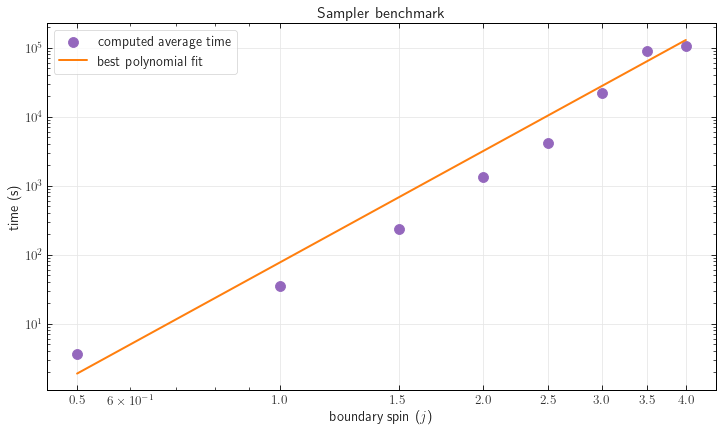

In [75]:
ax = df.plot(x='spin',
             y='run_times',
             s=100,
             xticks=corresponding_spin,
             kind='scatter',
             grid='false',
             color='tab:purple',
             label='computed average time',
             logy=True,
             logx=True,
             figsize=(12, 6.75))
df.plot(x='spin',
        y='fitted_data',
        ax=ax,
        kind='line',
        color='tab:orange',
        label='best polynomial fit')
plt.legend(fontsize = 14)
plt.ylabel("time (s)")
plt.xlabel("boundary spin ($j$)")
plt.title('Sampler benchmark', fontsize=16)
ax.xaxis.set_major_formatter(ScalarFormatter())

plt.show()